# Inverted pendulum with insufficient torque

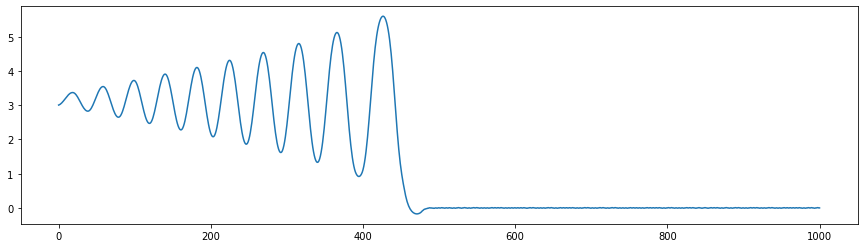

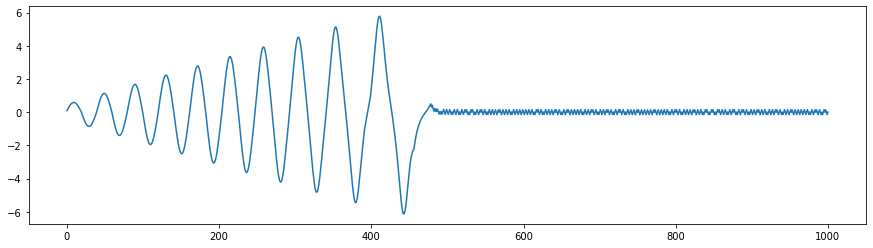

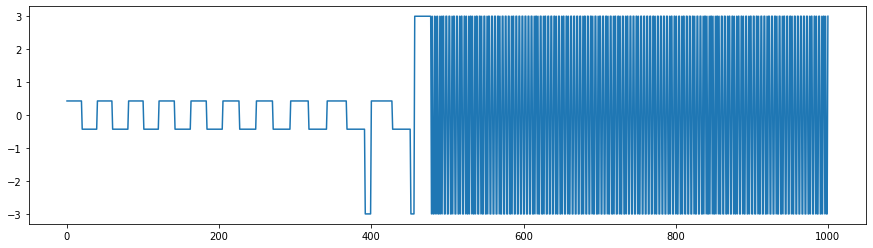

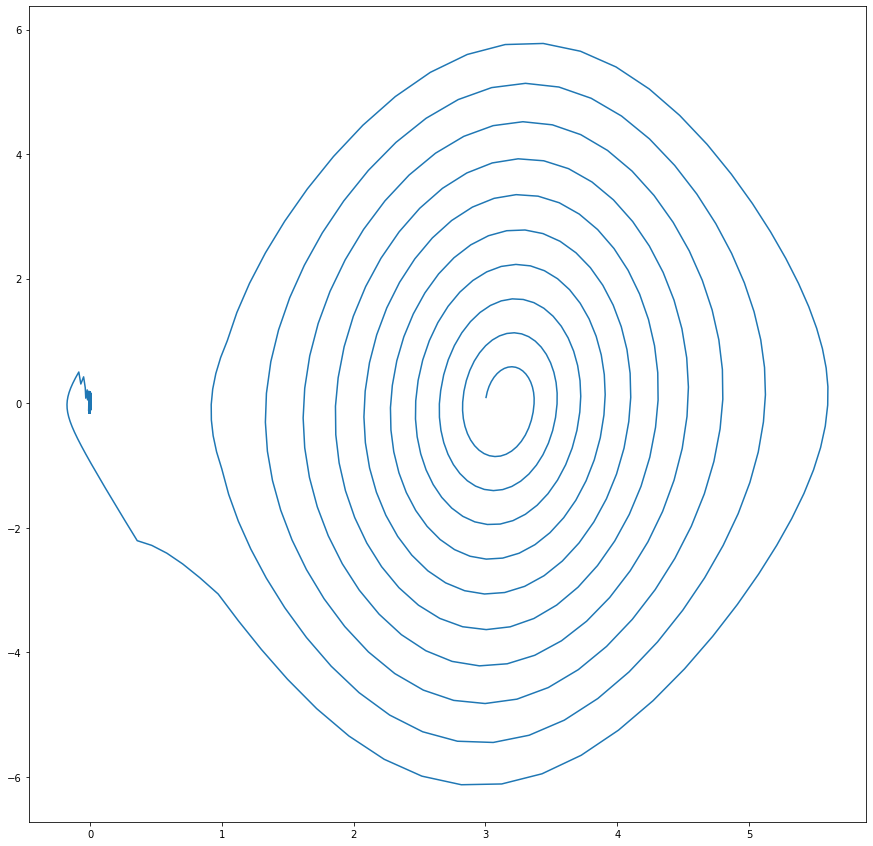

In [74]:
import numpy as np
import cv2
import math
import copy

class Weak_inverted_pendulum:
    def __init__(self, m = 1.0, l = 1.0, g = 10.0, x0 = 3, v0 = 0.0, dt = 0.05,
                 A0 = np.array([[0, 1],
                                [0, 0]]),
                 max_tau = 3):
        self.m = m
        self.l = l
        self.g = g
        self.max_tau = max_tau
        
        self.x = np.array([[x0], [v0]])
        self.dt = dt
        
        #state transition function
        self.A = A0
        self.A[1, 0] = - self.g / self.l
        
        #control -> xdot (matrix B from x_dot = Ax + Bu)
        self.B = np.array([[0], [1.0 / (self.m * self.l**2)]])
        
    def get_state(self):
        #print("state shape", self.x.shape)
        
        return self.x
    
    def sys_dyn(self, u):
        x_dot = np.zeros_like(self.x)
        
        u_effective = np.clip(u, -self.max_tau, self.max_tau)
        
        #x_dot = self.A @ self.x + self.B * u_effective
        x_dot = copy.deepcopy(self.x)
        x_dot[1] = self.g / self.l * math.sin(self.x[0]) + \
            u_effective / (self.m *self.l**2)
        
        #print(u_effective)
        
        x_dot[0] = self.x[1]
        
        return x_dot
    
    def integrate_sys_dyn(self, sys_dyn):
        #self.x = self.x + sys_dyn * self.dt
        
        self.x[1] += sys_dyn[1] * self.dt
        self.x[0] += self.x[1] * self.dt

def draw_pendulum(canvas, x, y, l, alpha, color = (123, 234, 234),
                  inverted = False):
    direction = 1
    
    if (inverted == True):
        direction = -1
    
    endpoint = (int(x - l * np.cos(alpha + direction * np.pi / 2)),
                int(y + l * np.sin(alpha + direction * np.pi / 2)))
    
    cv2.line(canvas, (x, y), endpoint, (123, 234, 234), 5)
    
    cv2.circle(canvas, endpoint, 25, color, -1)

def swing_up_feedback(x, max_tau = 5):
    if (abs(x[0, 0]) < 1):
        u = math.copysign(max_tau, - 5 * x[0, 0] - x[1, 0])

    else:
        u = math.copysign(max_tau / 7, x[1, 0])

    return u

def pendulum_energy(x, v, m = 1, l = 1, g = 10):
    #E = 
    
    return E

def energy_based_feedback(x, E = pendulum_energy, max_tau = 5):
    #delta_E = 
    
    u = math.copysign(max_tau, delta_E)

    return u

def run_pendulum_episode(iter_num = 1000, visualize = True):
    if (visualize == True):
        WIND_X = 700
        WIND_Y = 700
        canvas = np.ones((700, 700, 3), np.uint8) * 70
    
    pendulum = Weak_inverted_pendulum(x0 = 3)

    i = 0

    x_traj = []
    v_traj = []
    u_traj = []
    
    while(True):
        state = pendulum.get_state()

        control = swing_up_feedback(state, pendulum.max_tau)
        #control = energy_based_feedback(state)
        
        x_dot = pendulum.sys_dyn(control)
                
        pendulum.integrate_sys_dyn(x_dot)
        
        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control)
        
        i += 1

        if (i > iter_num):
            break

        if (visualize == True):
            canvas = cv2.addWeighted(canvas, 0.93, canvas, 0, 0)

            draw_pendulum(canvas, WIND_X // 2, WIND_Y // 2, 300,
                          state[0], (123, 234, 45), inverted = True)

            cv2.imshow("pendulum", canvas)

            key = cv2.waitKey(10) & 0xFF

            if (key == ord('q')):
                break
    
    if (visualize == True):
        cv2.destroyAllWindows()
        cv2.waitKey(10)
    
    return x_traj, v_traj, u_traj

x_hist, v_hist, u_hist = run_pendulum_episode()#visualize = False)

plot_1d(x_hist)
plot_1d(v_hist)
plot_1d(u_hist)

plt.figure(figsize=(15, 15))
plt.plot(x_hist, v_hist)
plt.show()

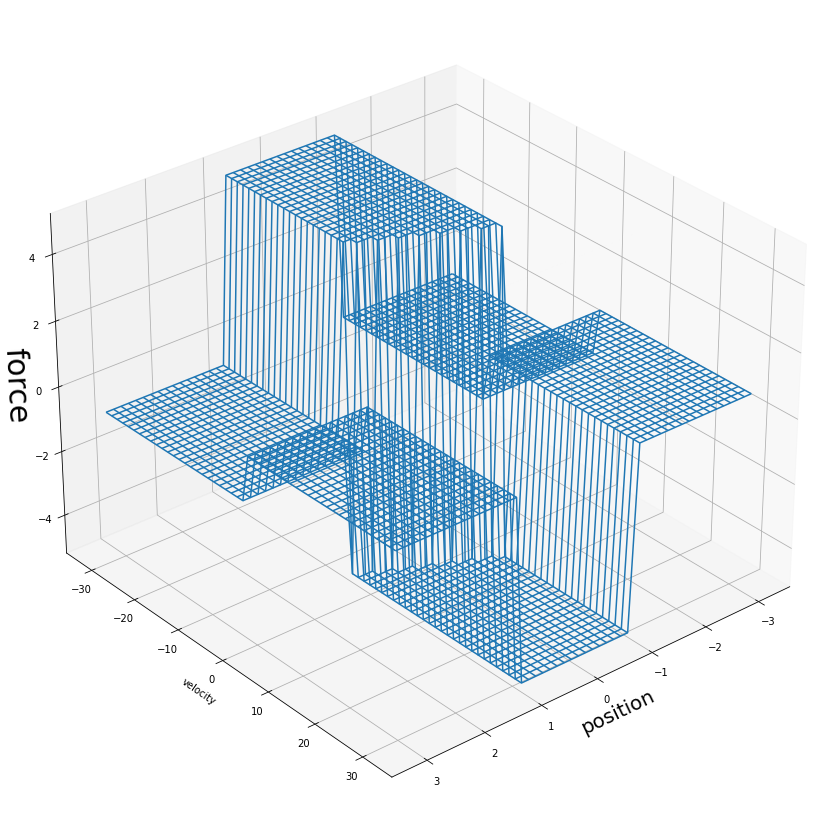

In [75]:
def visualize_function_3D(function, llim1, hlim1, a1name,
                          llim2, hlim2, a2name, pnum):
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111, projection='3d')

    X = np.linspace(llim1, hlim1, num = pnum)
    Y = np.linspace(llim2, hlim2, num = pnum)

    X, Y = np.meshgrid(X, Y)

    Z = X**2 + Y**2
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            x = X[i, j]
            y = Y[i, j]

            #print("x, y", (x, y))
            
            t = function(np.array([[x], [y]]))
            
            #t = np.clip(t, -30, 30)
            
            Z[i, j] = t
    
    ax.view_init(30, 50)
    ax.plot_wireframe(X, Y, Z)

    ax.set_xlabel(a1name, fontsize=20, rotation=150)
    ax.set_ylabel(a2name)
    ax.set_zlabel(r'force', fontsize=30, rotation=60)
        
    fig.canvas.draw()

    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    #return data

feedbacks = [swing_up_feedback]#, energy_based_feedback]

for feedback in feedbacks:
    visualize_function_3D(feedback, -math.pi, math.pi,
        "position", -5 * math.pi * 2, 5 * math.pi * 2, "velocity", 50)

# Linear MPC

$\frac{1}{2} x^T C x + d x \rightarrow \min$

$s.t. E x \leq f, A x = b$

https://inria.hal.science/hal-03683733/file/Yet_another_QP_solver_for_robotics_and_beyond.pdf/

In [ ]:
!pip install qpsolvers[proxqp]

In [67]:
import numpy as np
from qpsolvers import solve_qp

C = np.eye(2)
d = np.array([[0], [0]])

E = np.array([[ 1.0, - 1.0],
              [0, -1]])
f = np.array([[-3.0],
              [-3]])

x = solve_qp(C, d, E, f, solver="proxqp")

print(f"QP solution: {x = }")

QP solution: x = array([-9.30800749e-07,  2.99999934e+00])


In [ ]:
import numpy as np
from qpsolvers import solve_qp

def generate_controls(x_0, A, B, N, Q, R, F_max):
    ah, _  = A.shape
    bh, bw = B.shape
    qh, _  = Q.shape
    rh, _  = R.shape
    
    A_hat = np.zeros((ah * N, ah))
    B_hat = np.zeros((bh * N, bw * N))
    Q_hat = np.zeros((qh * N, qh * N))
    R_hat = np.zeros((rh * N, rh * N))
    
    # YOUR CODE BELOW
    
    
    
    # YOUR CODE ABOVE
    
    U = solve_qp(C, d, E, f, solver="proxqp")
    
    return U

A = np.array([[1.0, 1.0],
              [0.0, 1.0]])

B = np.array([[0.0],
              [1.0]])

Q = np.eye(2)

R = np.eye(1)

horizon = 3

F_max = 2

x_0 = np.array([[10], [1]])

print(generate_controls(x_0, A, B, horizon, Q, R, F_max))

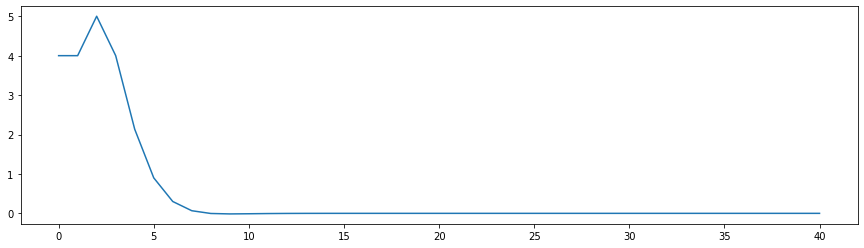

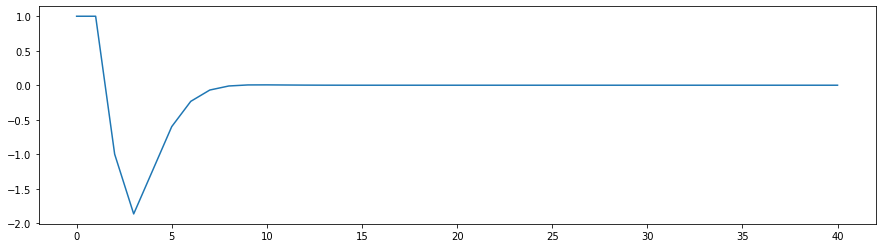

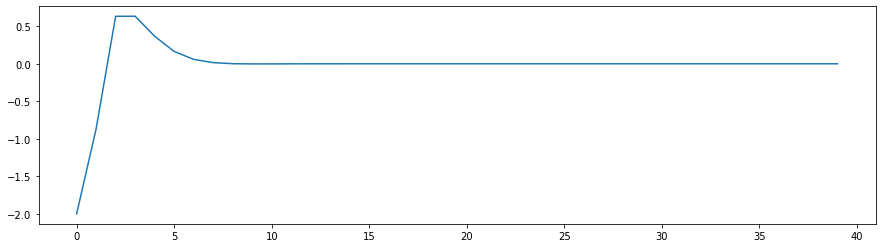

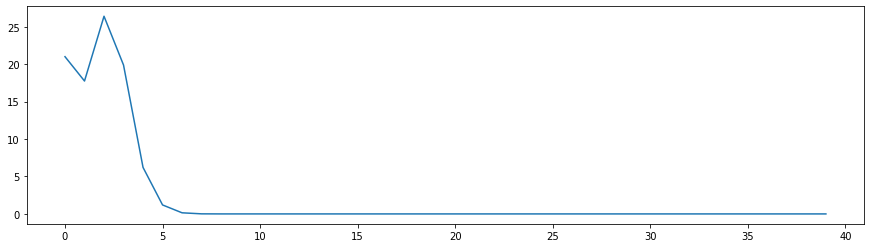

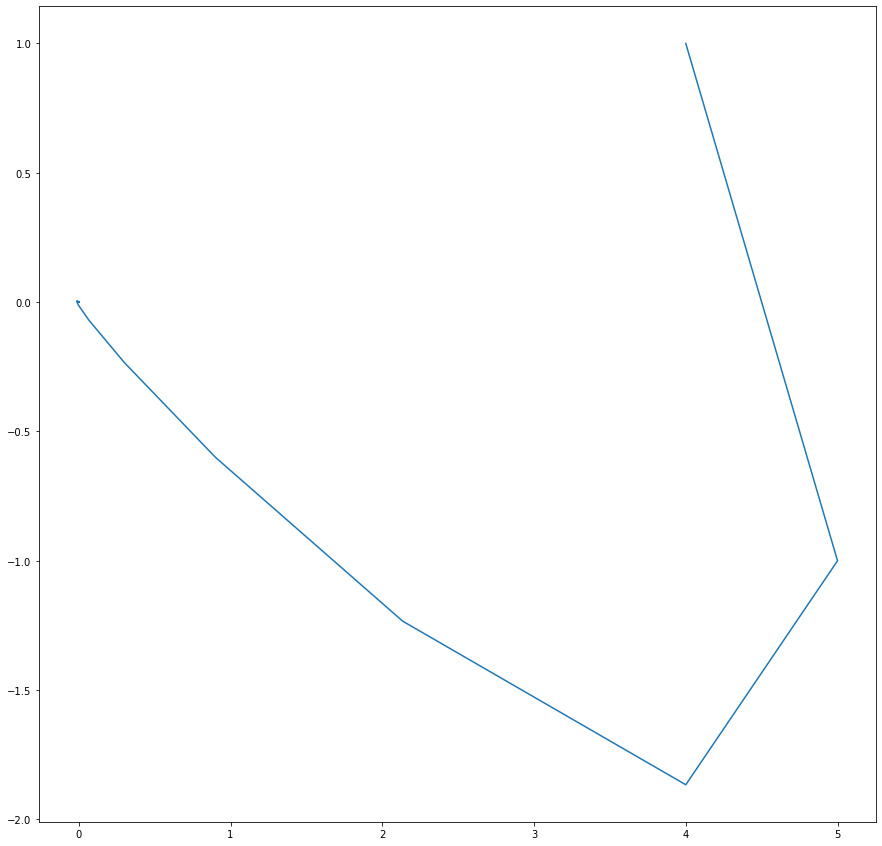

In [55]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from qpsolvers import solve_qp

def plot_1d(data):
    plt.figure(figsize=(15, 4))
    plt.plot(data)
    plt.show()

class Dyn_point_1D:
    def __init__(self, m = 1.0, x0 = 0.0, v0 = 0.0, A0 = np.array([[1, 1], [0, 1]])):
        self.m = m
        
        self.x = np.array([[x0], [v0]])
        
        #state transition function
        self.A = A0
        
        #control -> xdot (matrix B from x_{k+1} = Ax_k + Bu_k)
        self.B = np.array([[0], [1.0 / self.m]])
        
    def get_state(self):
        return self.x
        
    def propagate_system(self, u):
        self.x = self.A @ self.x + self.B * u

def state_action_cost(x, u, Q, R):    
    cost = x.T @ Q @ x + u.T @ R @ u
    
    return cost

def episode_cost(x_hist, v_hist, u_hist, Q, R):
    total_cost = 0
    cost_hist = []
    
    for x, v, u in zip(x_hist, v_hist, u_hist):
        
        x_vec = np.array([x, v])
        u_vec = np.array([u])
                
        cost = state_action_cost(x_vec, u_vec, Q, R)
        
        total_cost += cost
        cost_hist.append(cost)
    
    return total_cost, cost_hist

def run_episode(Q, R, x0 = 4.0, v0 = 2.0, A0 = np.array([[1, 1], [0, 1]])):
    dyn_point = Dyn_point_1D(x0 = x0, v0 = v0, A0 = A0)

    iter_num = 40
    i = 0

    horizon = 5
    
    F_max = 2
    
    #controls = generate_controls(dyn_point.x, dyn_point.A, dyn_point.B, horizon, Q, R, F_max)
    
    x_traj = [x0]
    v_traj = [v0]
    u_traj = []

    for i in range(iter_num):
        state = dyn_point.get_state()
        
        controls = generate_controls(state, dyn_point.A, dyn_point.B, horizon, Q, R, F_max)
        
        control = controls[0]
        
        dyn_point.propagate_system(control)

        x_traj.append(state[0, 0])
        v_traj.append(state[1, 0])
        u_traj.append(control)

        i += 1

        if (i > iter_num):
            break
    
    total_cost, cost_hist = episode_cost(x_traj, v_traj, u_traj, Q, R)

    plot_1d(x_traj)
    plot_1d(v_traj)
    plot_1d(u_traj)
    plot_1d(cost_hist)

    plt.figure(figsize=(15, 15))
    plt.plot(x_traj, v_traj)
    plt.show()
    
    return x_traj, v_traj, u_traj

Q = np.array([[1, 0],
              [0, 1]])

R = np.array([[1]])

_ = run_episode(Q, R, 4.0, 1.0)